In [1]:
from qiskit import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q')

from qiskit.ignis.characterization.gates import (AmpCalFitter, ampcal_1Q_circuits,
                                                 AngleCalFitter, anglecal_1Q_circuits,
                                                 AmpCalCXFitter, ampcal_cx_circuits,
                                                 AngleCalCXFitter, anglecal_cx_circuits)
backend = provider.get_backend('ibmqx2')

$$U_3 = Z_\text{something}(Z_{-\lambda +\theta -\frac{\pi}{2}}X_{\frac{\pi}{2}}Z_{\lambda -\theta +\frac{\pi}{2}})(Z_{\frac{\pi}{2}-\lambda}X_{\frac{\pi}{2}}Z_{\lambda - \frac{\pi}{2}})$$
$$U_2 = Z_{\lambda - \phi}(Z_{-\lambda}X_{\frac{\pi}{2}}Z_{\lambda})$$


In [2]:
backend = provider.get_backend('ibmq_burlington')

In [3]:
qubits = [0]
circs, xdata = ampcal_1Q_circuits(300, qubits)

In [ ]:
# Set the simulator
# Add a rotation error
err_unitary = np.zeros([2,2],dtype=complex)
angle_err = 0.10
for i in range(2):
    err_unitary[i,i] = np.cos(angle_err)
    err_unitary[i,(i+1) % 2] = np.sin(angle_err)
err_unitary[0,1] *= -1.0

error = coherent_unitary_error(err_unitary)
noise_model = NoiseModel()
noise_model.add_all_qubit_quantum_error(error, 'u2')

# Run the simulator
backend = qiskit.Aer.get_backend('qasm_simulator')
shots = 8192
backend_result1 = qiskit.execute(circs, backend,
                                shots=shots, noise_model=noise_model).result()

In [4]:
shots = 8192
backend_result1 = qiskit.execute(circs[:75], backend,
                                shots=shots).result()

In [5]:
shots = 8192
backend_result2 = qiskit.execute(circs[75:150], backend,
                                shots=shots).result()

In [8]:
shots = 8192
backend_result3 = qiskit.execute(circs[150:225], backend,
                                shots=shots).result()

In [9]:
shots = 8192
backend_result4 = qiskit.execute(circs[225:], backend,
                                shots=shots).result()

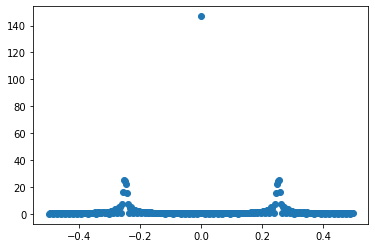

In [11]:
total_results = [*backend_result1.get_counts(),*backend_result2.get_counts(),*backend_result3.get_counts(),*backend_result4.get_counts()]
prob1 = []
for i in total_results:
    try:
        prob1.append(i['1']/8192)
    except:
        prob1.append(0)
fft = np.fft.fft(prob1)
plt.scatter(np.fft.fftfreq(len(fft)), list(map(np.abs, fft)))

In [12]:
dict(zip(np.fft.fftfreq(len(fft)), list(map(np.abs, fft))))

{0.0: 146.893310546875,
 0.0033333333333333335: 0.5142917150224651,
 0.006666666666666667: 0.5851236227039897,
 0.01: 0.8274252818874736,
 0.013333333333333334: 0.11538657300938472,
 0.016666666666666666: 0.35931550051229566,
 0.02: 0.5873652655660506,
 0.023333333333333334: 0.6875324993895583,
 0.02666666666666667: 0.22249856961566783,
 0.030000000000000002: 0.455353200664732,
 0.03333333333333333: 0.6848982943816097,
 0.03666666666666667: 0.5586971434613661,
 0.04: 0.22418192169047052,
 0.043333333333333335: 0.5517898813244414,
 0.04666666666666667: 0.7280009899363922,
 0.05: 0.4563494387461866,
 0.05333333333333334: 0.18368174447311642,
 0.05666666666666667: 0.5097519548836856,
 0.060000000000000005: 0.7406645825465352,
 0.06333333333333334: 0.6305327426068474,
 0.06666666666666667: 0.18980212623029882,
 0.07: 0.5956696994658673,
 0.07333333333333333: 0.7194111255758447,
 0.07666666666666667: 0.37072151570724016,
 0.08: 0.336469733494875,
 0.08333333333333334: 0.698643300696386,
 0.

In [ ]:
%matplotlib inline
# Fit the data to an oscillation

plt.figure(figsize=(15, 9))
initial_theta = 0.02
initial_c = 0.5
initial_phi = 0.1


fit = AmpCalFitter(backend_result1, xdata, qubits,
                   fit_p0=[initial_theta, initial_c],
                   fit_bounds=([-np.pi, -1],
                               [np.pi, 1]))

fit.plot(0, ax=plt.gca())

#plot analytic function

print("Rotation Error on U2: %f rads"%(fit.angle_err()[0]))
plt.show()

In [13]:
circs, xdata = anglecal_1Q_circuits(20, qubits, angleerr=0.05)
# Set the simulator
# Run the simulator
backend = qiskit.Aer.get_backend('qasm_simulator')
shots = 8192
backend_result2 = qiskit.execute(circs, backend, shots=shots).result()

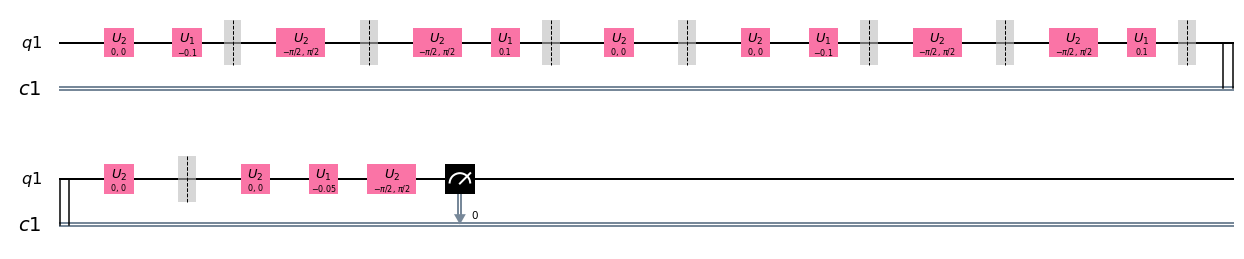

In [17]:
circs[2].draw(output='mpl')

Angle error between X and Y: 0.04902209426708962


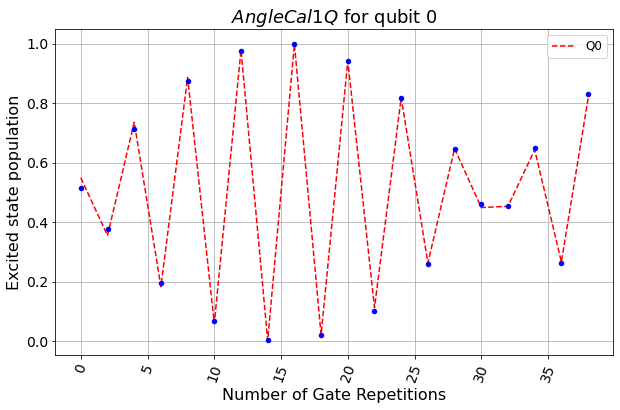

In [14]:
# Fit the data to an oscillation

plt.figure(figsize=(10, 6))
initial_theta = 0.02
initial_c = 0.5
initial_phi = 0.01


fit = AngleCalFitter(backend_result2, xdata, qubits,
                   fit_p0=[initial_theta, initial_c],
                   fit_bounds=([-np.pi, -1],
                               [np.pi, 1]))

fit.plot(0, ax=plt.gca())
print ("Angle error between X and Y: " + str(fit.angle_err()[0]))

plt.show()


In [ ]:
batch = []
for p in np.linspace(-np.pi, np.pi, 20):
    circ = QuantumCircuit(1,1)
    circ.u3(qubit=0,lam=0,theta=0, phi=p)
    circ.measure(0,0)
    batch.append(circ)

In [ ]:
job = qiskit.execute(batch, backend=backend, shots = 8192)

In [ ]:
job.result().get_counts()